# Solving double pendulum problem using Lagrange's equation

Defines a DoublePendulum class that is used to generate basic pendulum plots from solving Lagrange's equations.

Created by Yuqi Wang (wang.8615@osu.edu).

## Euler-Lagrange equation

For double pendulum, the Lagrangian with generalized coordinate $\phi_1$ and $\phi_2$ are

$\begin{align}
  \mathcal{L} = \frac12 (m_1+m_2) L_1^2 \dot\phi_1^2+ m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1-\phi_2)+\frac12 m_2 L_2^2 \dot\phi_2^2 - (m_1 + m_2) g L_1 (1-\cos\phi_1) - m_2 g L_2 (1-\cos\phi_1)
\end{align}$

The Euler-Lagrange equations are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad
 (m_1 + m_2) L_1^2 \ddot \phi_1 + m_2 L_1 L_2 \ddot \phi_2 \cos(\phi_1-\phi_2) - m_2 L_1 L_2 \dot \phi_2 \sin(\phi_1-\phi_2) (\dot \phi_1-\dot \phi_2)= -m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \sin(\phi_1-\phi_2) - (m_1 + m_2) g L_1 \sin\phi_1\\
  \;
  \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad
 m_2 L_1 L_2 \ddot \phi_1 \cos(\phi_1-\phi_2) - m_2 L_1 L_2 \dot \phi_1 \sin(\phi_1-\phi_2) (\dot \phi_1-\dot \phi_2)+m_2 L_2^2 \dot\phi_2^2=-m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \sin(\phi_1-\phi_2) - m_2 g L_2 \sin\phi_2
  \;
\end{align}$

Finally solve for $\ddot \phi_1$, $\ddot \phi_2$


$\begin{align}
 \ddot \phi_1 = \frac {m_2 g \sin\phi_2 \cos(\phi_1-\phi_2)- m_2 \sin(\phi_1-\phi_2) (L_1 \dot\phi_1^2 \cos(\phi_1-\phi_2) + L_2 \dot\phi_2^2) - (m_1+m_2) g \sin\phi_1} {L_1 (m_1 + m_2 \sin(\phi_1-\phi_2)^2)}\\
 \;
 \ddot \phi_2 = \frac {(m_1 + m_2) (L_1 \dot\phi_1^2 \sin(\phi_1-\phi_2) - g \sin\phi_2 + g \sin\phi_1 \cos(\phi_1-\phi_2)) + m_2 L_2 \dot\phi_2^2 \sin(\phi_1-\phi_2) \cos(\phi_1-\phi_2)} {L_2 (m_1 + m_2 \sin(\phi_1-\phi_2)^2)}
 \;
\end{align}$




In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [4]:
class DoublePendulum():
    """
    Pendulum class implements the parameters and Lagranges's equations for 
     double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of the massless rod that connects the pivot and the first mass
    L2 : float
        length of the massless rod that connects the second and the first mass
    g : float
        gravitational acceleration at the earth's surface
    mass1 : float
        mass of the first pendulum
    mass2 : float
        mass of the second pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, L1=1., L2=1., mass1=1., mass2=1., g=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.mass1 = mass1
        self.mass2 = mass2

    def dy_dt(self, t, y):
        
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt d^2phi1/dt^2 dphi2/dt d^2phi2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = phi1(t) and y[1] = dphi1/dt
            y[2] = phi2(t) and y[3] = dphi2/dt
            
        Returns
        -------
        
        """
        phi1, phi1_dot, phi2, phi2_dot = y
        c = np.cos(y[0]-y[2])
        s = np.sin(y[0]-y[2])
        cfactor=(self.mass1+self.mass2*s**2)
        phi1_double_dot=(self.mass2*self.g*np.sin(y[2])*c\
                         -self.mass2*s*(self.L1*y[1]**2*c+self.L2*y[3]**2)\
                         -(self.mass1+self.mass2)*self.g*np.sin(y[0]))/self.L1/cfactor
        phi2_double_dot=((self.mass1+self.mass2)*(self.L1*y[1]**2*s-self.g*np.sin(y[2])+self.g*np.sin(y[0])*c)\
                         +self.mass2*self.L2*y[3]**2*s*c)/self.L2/cfactor
        
        return phi1_dot, phi1_double_dot, phi2_dot, phi2_double_dot
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0,
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot= solution.y

        return phi1, phi1_dot, phi2, phi2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Part (a) : Make pendulum plots

In [7]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
delta_phi_vs_time_labels = (r'$t$', r'$\Delta\phi(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate two pendulums 
p1 = DoublePendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)


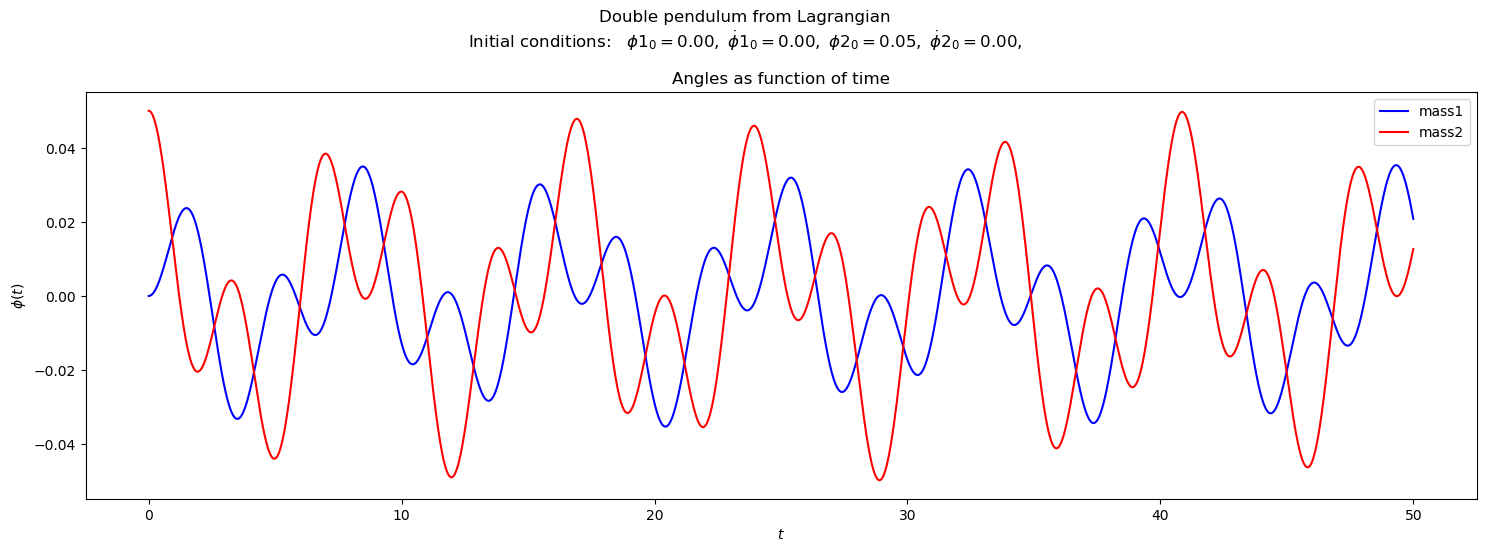

In [8]:
phi1_0 = 0
phi1_dot_0 = 0
phi2_0 = 0.05
phi2_dot_0 = 0
phi1, phi1_dot, phi2, phi2_dot= p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian' + \
                '\n' + \
                'Initial conditions:  ' + \
                rf' $\phi1_0 = {phi1_0:.2f},$' + \
                rf' $\dot\phi1_0 = {phi1_dot_0:.2f},$' + \
                rf' $\phi2_0 = {phi2_0:.2f},$' + \
                rf' $\dot\phi2_0 = {phi2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label='mass1', 
            title='Angles as function of time', 
            ax=ax_a)  

plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label='mass2', 
            ax=ax_a)  

fig.tight_layout()
fig.savefig('double_pendulum_Lagrange(1).pdf', bbox_inches='tight')  

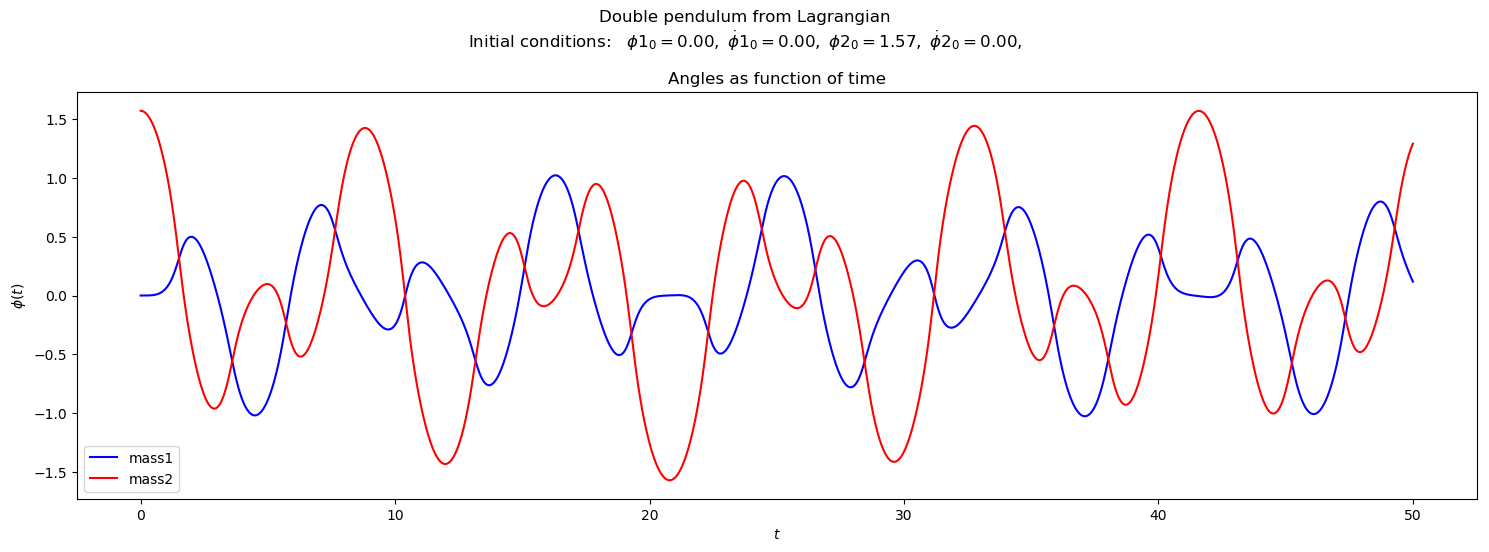

In [9]:
phi1_0 = 0
phi1_dot_0 = 0
phi2_0 = np.pi/2
phi2_dot_0 = 0
phi1, phi1_dot, phi2, phi2_dot= p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian' + \
                '\n' + \
                'Initial conditions:  ' + \
                rf' $\phi1_0 = {phi1_0:.2f},$' + \
                rf' $\dot\phi1_0 = {phi1_dot_0:.2f},$' + \
                rf' $\phi2_0 = {phi2_0:.2f},$' + \
                rf' $\dot\phi2_0 = {phi2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label='mass1', 
            title='Angles as function of time',  
            ax=ax_a)  

plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label='mass2', 
            ax=ax_a)  

fig.tight_layout()
fig.savefig('double_pendulum_Lagrange(2).pdf', bbox_inches='tight')  

## Part (b) : Show that the system is chaotic for initial conditions beyond small angle approximation

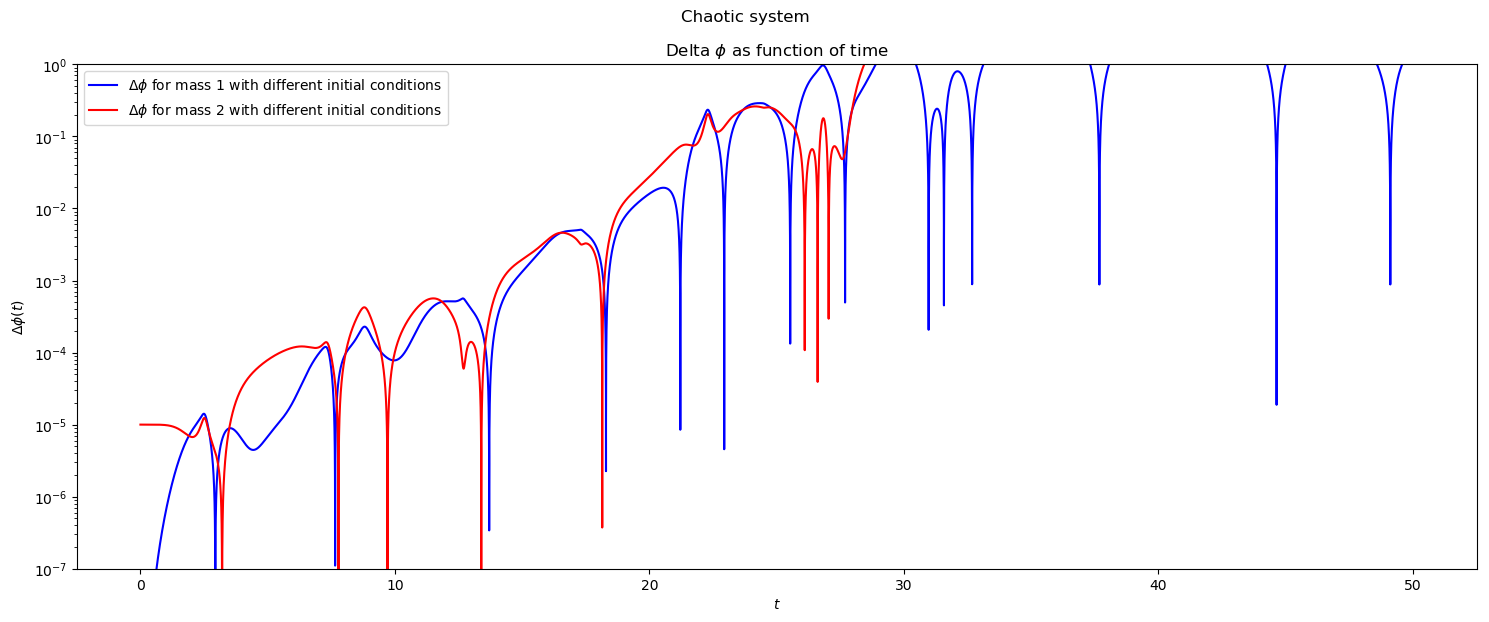

In [10]:
phi1_01 = np.pi/2
phi1_dot_01 = 0
phi2_01 = np.pi
phi2_dot_01 = 0
phi1_1, phi1_dot_1, phi2_1, phi2_dot_1= p1.solve_ode(t_pts, phi1_01, phi1_dot_01, phi2_01, phi2_dot_01)

phi1_02 = np.pi/2
phi1_dot_02 = 0
phi2_02 = np.pi-0.00001
phi2_dot_02 = 0
phi1_2, phi1_dot_2, phi2_2, phi2_dot_2= p1.solve_ode(t_pts, phi1_02, phi1_dot_02, phi2_02, phi2_dot_02)

delta_phi1= np.fabs(phi1_2-phi1_1)
delta_phi2= np.fabs(phi2_2-phi2_1)

# start the plot!
fig = plt.figure(figsize=(15,6))
overall_title = 'Chaotic system' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# Delta phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], delta_phi1[start : stop], 
            axis_labels=delta_phi_vs_time_labels, 
            color='blue',
            label='$\Delta\phi$ for mass 1 with different initial conditions', 
            semilogy = True,
            title=r'Delta $\phi$ as function of time', 
            ax=ax_a)  

plot_y_vs_x(t_pts[start : stop], delta_phi2[start : stop], 
            axis_labels=delta_phi_vs_time_labels, 
            color='red',
            label='$\Delta\phi$ for mass 2 with different initial conditions', 
            semilogy = True,
            ax=ax_a)  

ax_a.set_ylim(1.e-7,1.)
fig.tight_layout()
fig.savefig('chaotic.pdf', bbox_inches='tight')  

## Part (e) : Widgets

In [11]:
# Import explicitly the widgets we might use (add more as needed!) 
import ipywidgets as widgets
from ipywidgets import interact, HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 

from IPython.display import display

In [12]:
def my_function1(phi1_0 = 0, phi1_dot_0 = 0, phi2_0 = 0.05, phi2_dot_0 = 0, \
                 L1=1., L2=1., mass1=1., mass2=1., g=1.):
    t_start = 0.
    t_end = 50.
    delta_t = 0.001

    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    # Instantiate pendulum 
    p1 = DoublePendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)

    phi1, phi1_dot, phi2, phi2_dot= p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)
    
    return phi1

def my_function2(phi1_0 = 0, phi1_dot_0 = 0, phi2_0 = 0.05, phi2_dot_0 = 0, \
                 L1=1., L2=1., mass1=1., mass2=1., g=1.):
    t_start = 0.
    t_end = 50.
    delta_t = 0.001

    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    # Instantiate pendulum
    p1 = DoublePendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)

    phi1, phi1_dot, phi2, phi2_dot= p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)
    
    return phi2


def pendulum_plot(phi1_0 = 0, phi1_dot_0 = 0, phi2_0 = 0.05, phi2_dot_0 = 0, \
                  L1=1., L2=1., mass1=1., mass2=1., g=1.):

    t_start = 0.
    t_end = 50.
    delta_t = 0.001

    t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

    # Instantiate pendulum
    p1 = DoublePendulum(L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g)

    phi1, phi1_dot, phi2, phi2_dot= p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)
    
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line, = ax.plot(t_pts, my_function1(phi1_0 = phi1_0, phi2_0 = phi2_0, \
                                        phi1_dot_0 = phi1_dot_0, phi2_dot_0 = phi2_dot_0, \
                                        L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g),
                    lw=2, color='blue', label='mass1', )
    line, = ax.plot(t_pts, my_function2(phi1_0 = phi1_0, phi2_0 = phi2_0, \
                                        phi1_dot_0 = phi1_dot_0, phi2_dot_0 = phi2_dot_0, \
                                        L1=L1, L2=L2, mass1=mass1, mass2=mass2, g=g),
                    lw=2, color='red', label='mass2', )
    ax.legend()
    

In [13]:
phi1_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\phi1_0$ :', continuous_update=False)
phi1_dot_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\dot\phi1_0$ :', continuous_update=False)
phi2_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\phi2_0$ :', continuous_update=False)
phi2_dot_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\dot\phi2_0$ :', continuous_update=False)
L1_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$L1$ :', continuous_update=False)
L2_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$L2$ :', continuous_update=False)
mass1_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$mass1$ :', continuous_update=False)
mass2_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$mass2$ :', continuous_update=False)
g_w = FloatSlider(value=1.0, min=.1, max=10., step=0.1,
                      description=r'$g$ :', continuous_update=False)

In [14]:
plot_out = widgets.interactive_output(pendulum_plot,
                                      dict(
                                      phi1_0=phi1_0_w,
                                      phi1_dot_0=phi1_dot_0_w,
                                      phi2_0=phi2_0_w,
                                      phi2_dot_0=phi2_dot_0_w,
                                      L1=L1_w,
                                      L2=L2_w,
                                      mass1=mass1_w,
                                      mass2=mass2_w,
                                      g=g_w,
                                      )
                                     )

In [15]:
hbox_1 = HBox([phi1_0_w,phi2_0_w])
hbox_2 = HBox([phi1_dot_0_w,phi2_dot_0_w])
hbox_3 = HBox([L1_w, L2_w])
hbox_4 = HBox([mass1_w, mass2_w])
hbox_5 = HBox([g_w])
UI_box = VBox([hbox_1, hbox_2, hbox_3, hbox_4, hbox_5, plot_out])

In [16]:
display(UI_box)